## Imports

In [4]:
!pip install unzip

In [1]:
from torch.utils.data import DataLoader
from torch.autograd import Variable
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
import zipfile

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import gwpy
from gwpy.timeseries import TimeSeries
from os import listdir
import h5py as h5
import os

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [3]:
device

'cuda'

In [7]:
# device = 'cpu'
# Tensor = torch.Tensor

## Load Data

### Load Data from h5

In [4]:
def construct_dataframe(path, n1_events=None, n2_events=None,channels=None,print_=False):
    if not n1_events:
        n1_events=0
    if not n2_events:
        n2_events=len(listdir(path))
        
    if n2_events>len(listdir(path)):
        n2_events=len(listdir(path))
    
        
    lstdr=listdir(path)[n1_events:n2_events]
    sample_file=listdir(path)[0]
    
    files = [f for f in lstdr]
    df_list = []
    event_data = []
    
    n_all_channels=0
    all_channels=[]
    
    with h5.File(os.path.join(path, sample_file), 'r') as fout:
        event_id = list(fout.keys())[0]
        all_channels=list(fout[event_id])
        n_all_channels=len(list(fout[event_id]))
        
    
    if not channels:
        channels=all_channesl
    
    try:
        channels.remove('V1:Hrec_hoft_16384Hz')
    except:
        pass
    
    
    for i, file in enumerate(files):
        if print_:
            print(f"Added {i + 1}/{n2_events - n1_events} files to dataframe", end='\r')
       
           
        try:
            with h5.File(os.path.join(path, file), 'r') as fout:
                event_id = list(fout.keys())[0]
                #dictionary = {'Event ID': event_id}
                dictionary={}
                #event_data.append(event_id)
                
                
                tmsrs = TimeSeries(fout[event_id]['V1:Hrec_hoft_16384Hz'])
                tensor_data = torch.tensor(tmsrs.value)
                dictionary['V1:Hrec_hoft_16384Hz'] = [tensor_data]
                
                for channel in channels:
                    tmsrs = TimeSeries(fout[event_id][channel])
                    tensor_data = torch.tensor(tmsrs.value)
                    dictionary[channel] = [tensor_data]
                df_list.append(pd.DataFrame(dictionary))
        except Exception as e:
            if print_:
                print(f'COULD NOT OPEN {os.path.join(path, file)}')
                print(e)
            
        
        
    
    df = pd.concat(df_list, ignore_index=True)
    #df_ids = pd.DataFrame({'Event ID': event_data})
    #df = pd.concat([df_ids, df], axis=1)
    
    return df

In [17]:
df=construct_dataframe(path='/data/datasets/intertwin-dati-aux/gspy_O3a_Scattered_Light_V1',channels=['V1:Hrec_hoft_16384Hz','V1:LSC_MICH_ERR','V1:LSC_NE_CORR','V1:LSC_PR_CORR'],print_=True)

COULD NOT OPEN /data/datasets/intertwin-dati-aux/gspy_O3a_Scattered_Light_V1/LWrVkYvFcD.h5
Unable to synchronously open file (bad object header version number)
COULD NOT OPEN /data/datasets/intertwin-dati-aux/gspy_O3a_Scattered_Light_V1/Shift_VS_Correlation.png
Unable to synchronously open file (file signature not found)


In [19]:
df.to_pickle('/data/notebooks_intertwin/Dataset_all.pkl')

### Load Data from pkl

In [69]:
# Load alternative datasets

#df = pd.read_pickle('/data/notebooks_intertwin/Dataset_all.pkl')
#df = pd.read_pickle('/data/notebooks_intertwin/Dataset_0_100.pkl')
#df = pd.read_pickle('/data/notebooks_intertwin/Dataset_0_3000_stand.pkl')

**Load full dataset resampled to 500Hz and normalised** (according to def standardise(ts))

In [4]:
df=pd.read_pickle('/data/notebooks_intertwin/Dataset_all_norm_resampled_500hz.pkl')

Clean dataset by eliminating rows with Nan values

In [5]:
nan_rows = df[df.apply(lambda row: any(torch.isnan(x).any() for x in row), axis=1)].index
nan_rows
len(nan_rows)
#df_filtered = df.drop(nan_rows)

90

In [7]:
df_filtered = df.drop(nan_rows)

(11792, 4)

## Preprocess Data & Stats: do not run if working with already preprocessed data

### Visualise data

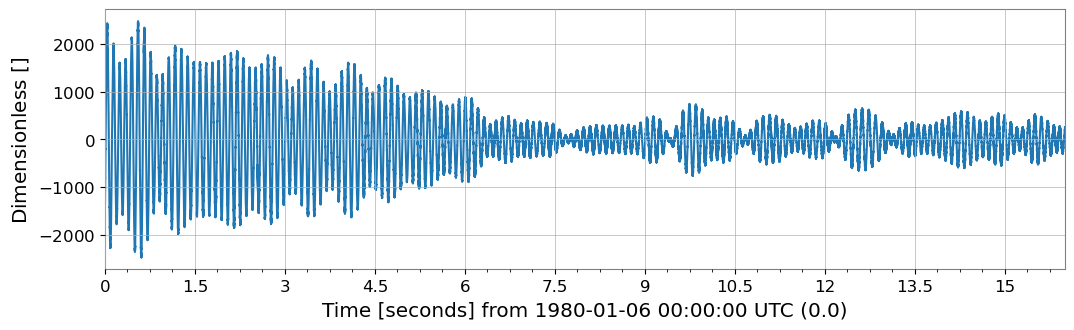

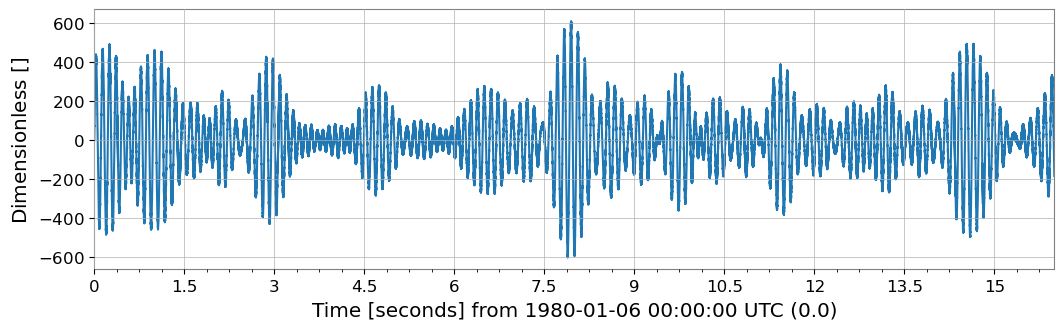

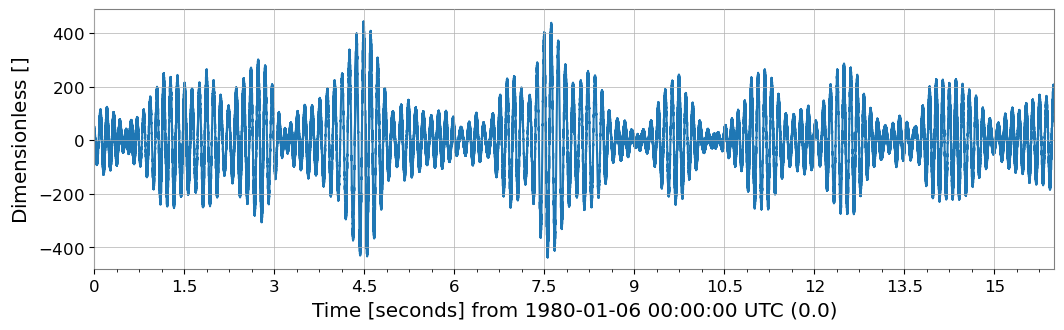

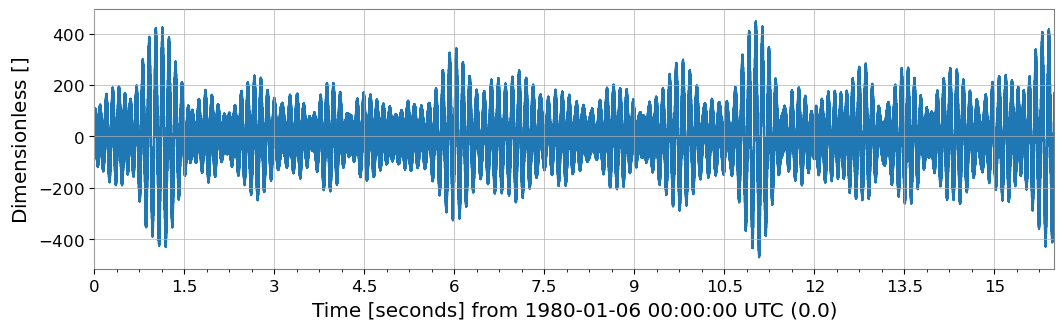

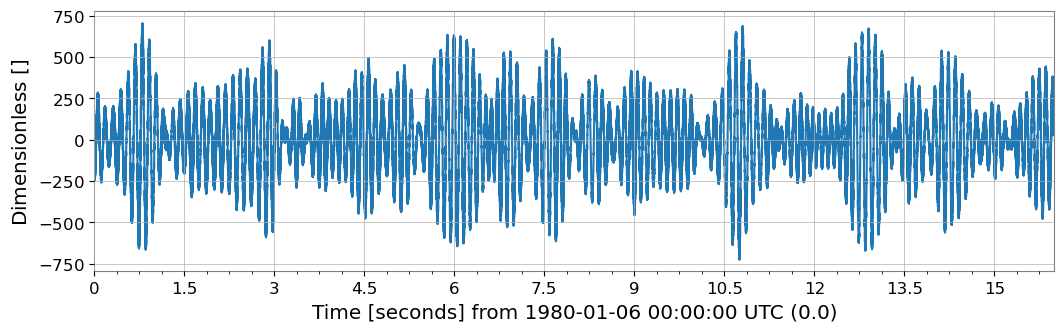

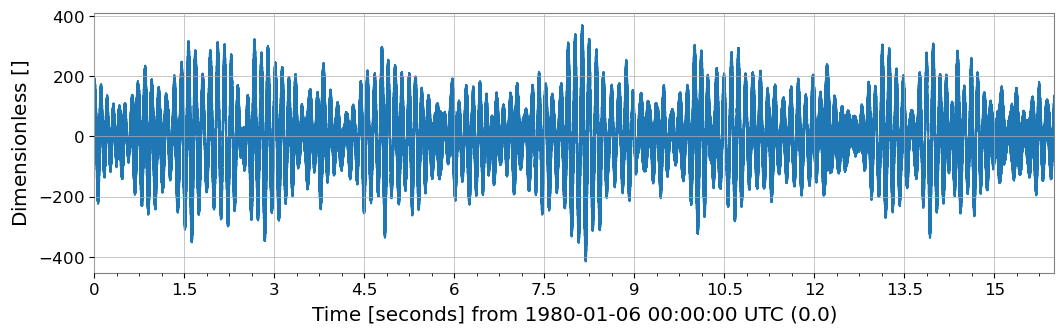

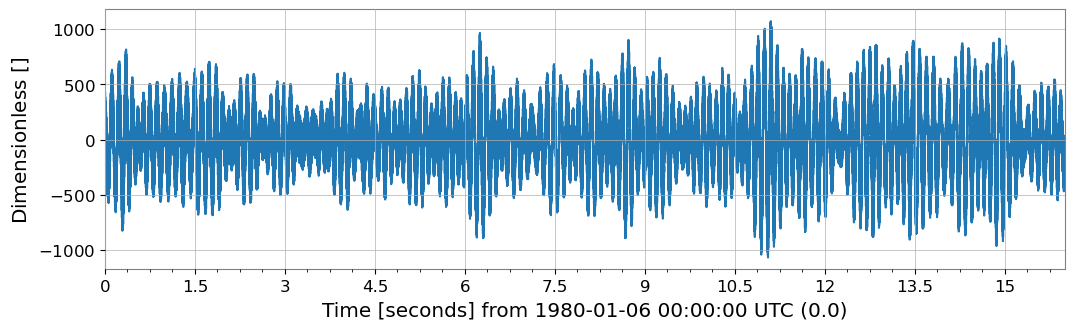

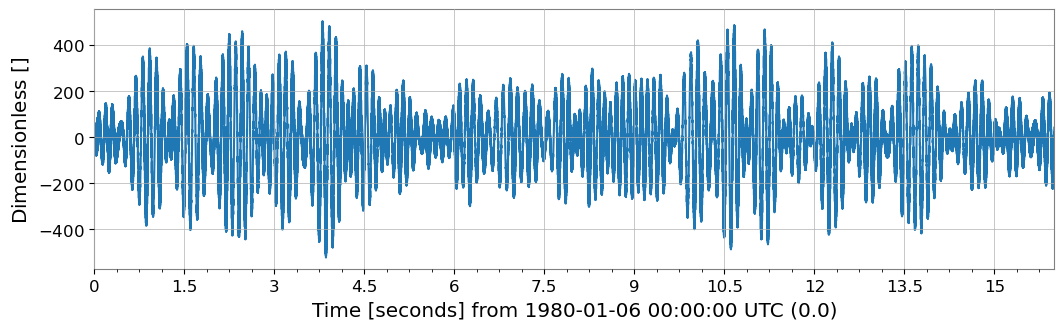

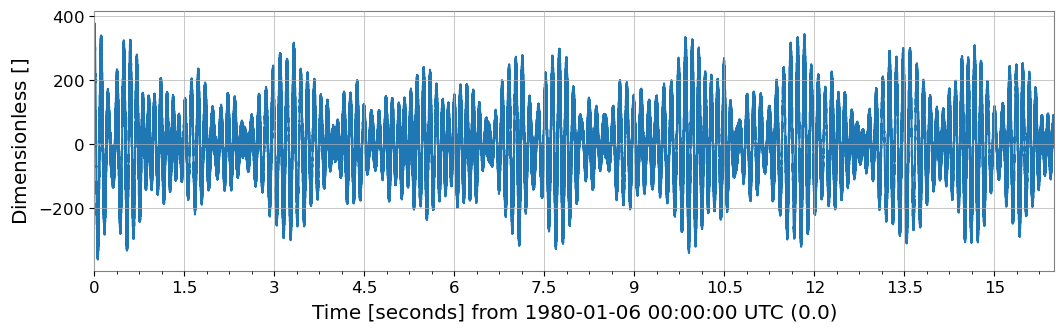

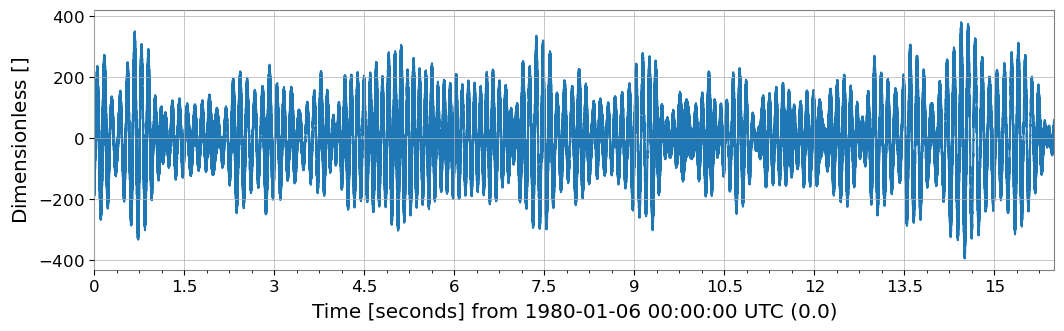

In [83]:
for i in range(10):    
    original_ts= TimeSeries(df.loc[i,'V1:Hrec_hoft_16384Hz'],dt=1.0/4096.0)
    original_ts.plot()
plt.show()

### Normalize Data

In [6]:
def normalize_data(entry):
    st_dev=entry.std()
    mean=entry.mean()
    return (entry-mean)/st_dev
 
df_norm=df.applymap(lambda t: normalize_data(t))

In [26]:
df_norm.head()

V1:Hrec_hoft_16384Hz   
0  [tensor(-1.8859, dtype=torch.float64), tensor(...  \
1  [tensor(0.0601, dtype=torch.float64), tensor(0...   
2  [tensor(0.0675, dtype=torch.float64), tensor(0...   
3  [tensor(1.3127, dtype=torch.float64), tensor(0...   
4  [tensor(-1.3454, dtype=torch.float64), tensor(...   

                                     V1:LSC_MICH_ERR   
0  [tensor(0.3339), tensor(0.9402), tensor(0.8023...  \
1  [tensor(0.4151), tensor(0.8464), tensor(0.7554...   
2  [tensor(-0.5998), tensor(-1.1146), tensor(-0.9...   
3  [tensor(-0.3663), tensor(-0.8875), tensor(-0.7...   
4  [tensor(0.2812), tensor(1.2526), tensor(1.0335...   

                                      V1:LSC_NE_CORR   
0  [tensor(1.6409), tensor(1.9889), tensor(1.9101...  \
1  [tensor(1.6771), tensor(2.4666), tensor(2.2885...   
2  [tensor(1.8672), tensor(2.0991), tensor(2.0467...   
3  [tensor(0.8144), tensor(1.4278), tensor(1.2894...   
4  [tensor(-0.9546), tensor(-1.4378), tensor(-1.3...   

                                      V1:LSC_PR_CORR  
0  [tensor(1.8625), tensor(3.0390), tensor(2.7728...  
1  [tensor(-0.6955), tensor(-1.2076), tensor(-1.0...  
2  [tensor(-0.3637), tensor(-1.8308), tensor(-1.4...  
3  [tensor(-1.2447), tensor(-1.0743), tensor(-1.0...  
4  [tensor(0.6024), tensor(0.5116), tensor(0.5370...

In [23]:
import torch
import pandas as pd

def stats_mean(entry):
    mean = entry.mean().item()
    return mean

def stats_sd(entry):
    st_dev = entry.std().item()
    return st_dev

def stats_min_max(entry):
    max_=entry.max().item()
    min_=entry.min().item()
    return max_-min_

# Apply the functions to each entry in the DataFrame
df_stats_sd = df.applymap(lambda t: stats_sd(t))
df_stats_mean = df.applymap(lambda t: stats_mean(t))
df_stats_min_max= df.applymap(lambda t: stats_min_max(t))

In [40]:
def standardise(ts):
    mx=ts.max()
    mn=ts.min()
    ts_std=(ts-mn)/(mx-mn)-0.5
    return ts_std 


In [41]:
def whiten_data(t,sr):
    ts=TimeSeries(t,dt=1.0/sr)
    ts_w=ts.whiten()
    t=torch.tensor(ts_w.value)
    return t

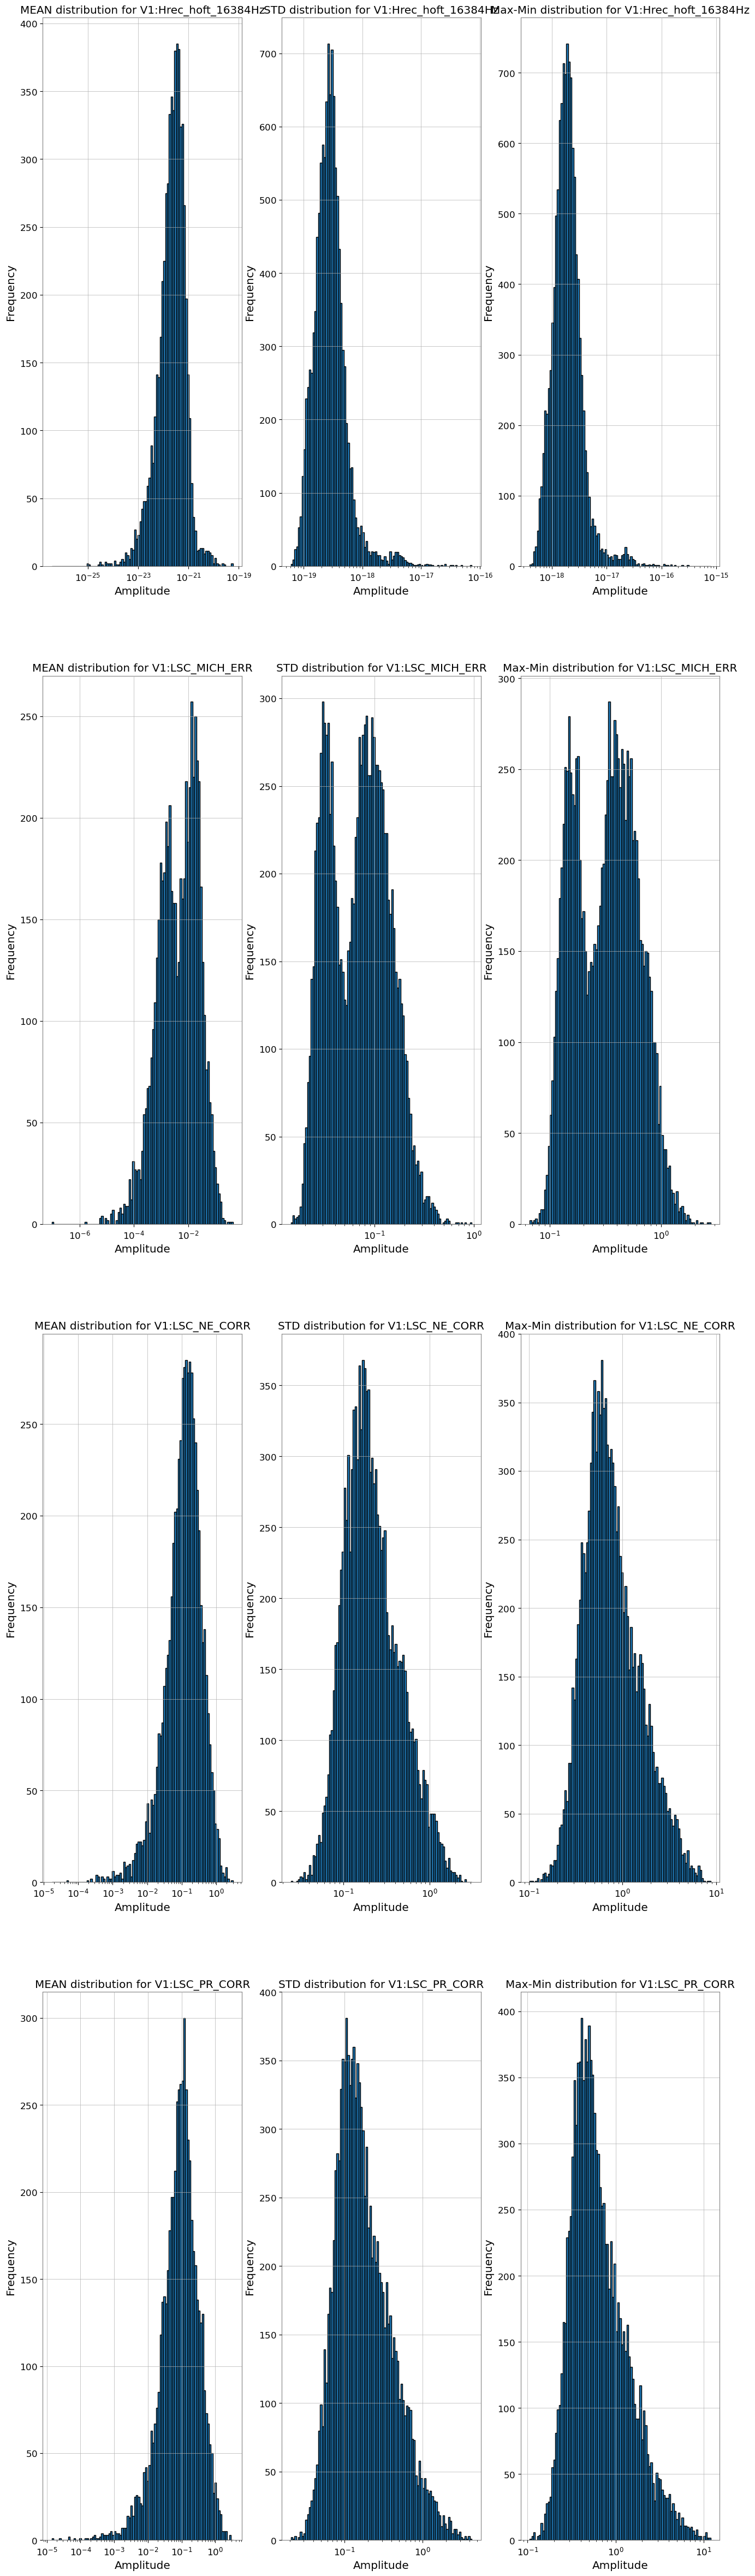

In [24]:
fig, ax = plt.subplots(4,3,figsize=[16, 6*10])
for i in range(len(list(df.columns))):
    ax[i,0].hist(df_stats_mean[list(df.columns)[i]], bins=np.logspace(np.log10(abs(df_stats_mean[list(df.columns)[i]]).min()), np.log10(df_stats_mean[list(df.columns)[i]].max()), 100), edgecolor='black')  # You can adjust the number of bins as needed
    ax[i,0].set_title(f'MEAN distribution for {list(df.columns)[i]}')
    ax[i,0].set_xlabel('Amplitude')
    ax[i,0].set_ylabel('Frequency')
    ax[i,0].set_xscale('log', base=10)
    
    ax[i,1].hist(df_stats_sd[list(df.columns)[i]], bins=np.logspace(np.log10(abs(df_stats_sd[list(df.columns)[i]]).min()), np.log10(df_stats_sd[list(df.columns)[i]].max()), 100), edgecolor='black')  # You can adjust the number of bins as needed
    ax[i,1].set_title(f'STD distribution for {list(df.columns)[i]}')
    ax[i,1].set_xlabel('Amplitude')
    ax[i,1].set_xscale('log', base=10)
    
    ax[i,2].hist(df_stats_min_max[list(df.columns)[i]], bins=np.logspace(np.log10(abs(df_stats_min_max[list(df.columns)[i]]).min()), np.log10(df_stats_min_max[list(df.columns)[i]].max()), 100), edgecolor='black')  # You can adjust the number of bins as needed
    ax[i,2].set_title(f'Max-Min distribution for {list(df.columns)[i]}')
    ax[i,2].set_xlabel('Amplitude')
    ax[i,2].set_xscale('log', base=10)
    
    ax[i,1].set_ylabel('Frequency')
    ax[i,2].set_ylabel('Frequency')

plt.savefig('stats_all.png')
plt.show()


In [36]:
filtered_rows = df_stats_sd[df_stats_sd['V1:Hrec_hoft_16384Hz'] > 0.4]
filtered_rows

V1:Hrec_hoft_16384Hz  V1:LSC_MICH_ERR  V1:LSC_NE_CORR  V1:LSC_PR_CORR
0               683.799833      6668.479272    3.801034e+06    92120.152997
1               173.104466       562.151832    2.424327e+06    18332.928197
2               122.396056       999.419832    1.496393e+06     1459.199538
3               116.638878      1376.923285    7.508187e+05     3263.285193
4               240.425729      2297.347692    7.091189e+05     9272.558784
...                    ...              ...             ...             ...
2995            112.022131      2686.574700    1.905281e+06    25478.136250
2996            159.413098      1199.979972    1.596610e+06    13542.630300
2997            208.184266       317.162148    1.490175e+06     2893.032993
2998            244.893629      1721.010570    1.166491e+06     7995.958045
2999             91.384695      1009.024099    1.528889e+06     8833.656541

[3000 rows x 4 columns]

In [ ]:
fig, ax = plt.subplots(10,2,figsize=[20, 10*10])
for i in range(10):
    ts=TimeSeries(df_norm.loc[i,'V1:LSC_MICH_ERR'],dt=1.0/4096.0)
    original_ts= TimeSeries(df.loc[i,'V1:LSC_MICH_ERR'],dt=1.0/4096.0)
    
    ax[i,0].plot(ts,color='b',label='processed' )
    ax[i,1].plot(original_ts, color='r',label='original')
    
    # qt=ts.q_transform(frange=(10,100))
    # qt_original=original_ts.q_transform(frange=(10,100))
    # plot = ax[i,2].imshow(qt, cmap='viridis', aspect='auto', origin='lower', vmin=0, vmax=25)
    # plot = ax[i,3].imshow(qt_original, cmap='viridis', aspect='auto', origin='lower', vmin=0, vmax=25)
    
    
    # Set x-axis scale to seconds
    ax[i,0].set_xscale('seconds')
    ax[i,1].set_xscale('seconds')
    # ax[i,2].set_xscale('seconds')
    # ax[i,3].set_xscale('seconds')

    # Set y-axis scale to log with base 2
    # ax[i,2].set_yscale('log', base=2)
    # ax[i,2].set_ylim(10, 2048)
    # ax[i,3].set_yscale('log', base=2)
    # ax[i,3].set_ylim(10, 2048)
    #ax.set_xlim(gps-2, gps+2)

    # Set labels and colorbar
    # ax[i,2].set_ylabel('Frequency [Hz]')
    # ax[i,2].set_ylabel('Frequency [Hz]')
    
    #plt.colorbar(plot, ax=ax[i, 2], label='Intensity')
    
    ax[i,0].set_title('processed')
    ax[i,1].set_title('original')
    # ax[i,2].set_title('processed')
    # ax[i,3].set_title('original')
    ax[i,0].set_xlabel('Time [seconds]')
    ax[i,1].set_xlabel('Time [seconds]')
    # ax[i,2].set_xlabel('Time [seconds]')
    # ax[i,3].set_xlabel('Time [seconds]')
    

plt.show()   

### Resample Data

In [42]:
import torchaudio.transforms
import torchaudio.functional as F

In [43]:
def resample_tensor(input_tensor, original_rate, new_rate):

    # Resample the tensor using torchaudio.functional.resample
    resampled_tensor = F.resample(input_tensor,orig_freq=original_rate,new_freq=new_rate)

    return resampled_tensor

In [70]:
df_resampled=df.applymap(lambda t: resample_tensor(t,4096,500))
df_w=df_resampled.applymap(lambda t: whiten_data(t,500.0))
df_stand=df_w.applymap(lambda t: standardise(t))

In [45]:
save_name='/data/notebooks_intertwin/Dataset_all_norm_resampled_500hz'
df_stand.to_pickle(f'{save_name}.pkl')

In [17]:
# df_resampled=df.applymap(lambda t: resample_tensor(t,4096,500))
# df_stand2=df_resampled.applymap(lambda t: standardise(t))
# df_w2=df_stand2.applymap(lambda t: whiten_data(t,500))

In [60]:
df_stand.iloc[0,0]

tensor([-0.0557, -0.0959, -0.1291,  ...,  0.0133,  0.0432,  0.0440],
       dtype=torch.float64)

In [52]:
df_resampled.iloc[0,0].shape

torch.Size([8000])

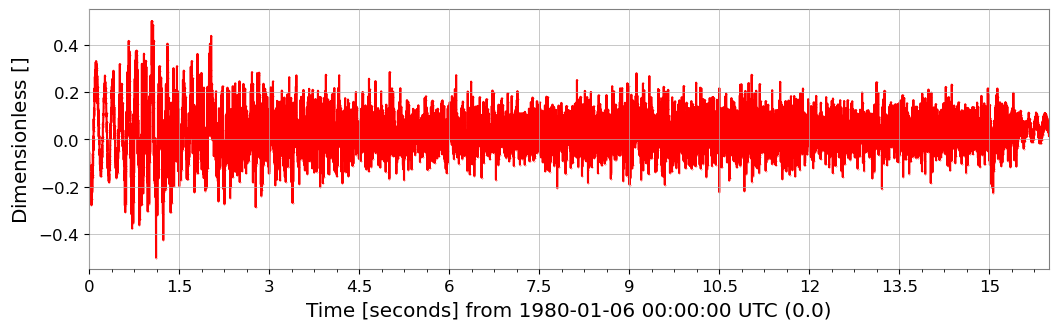

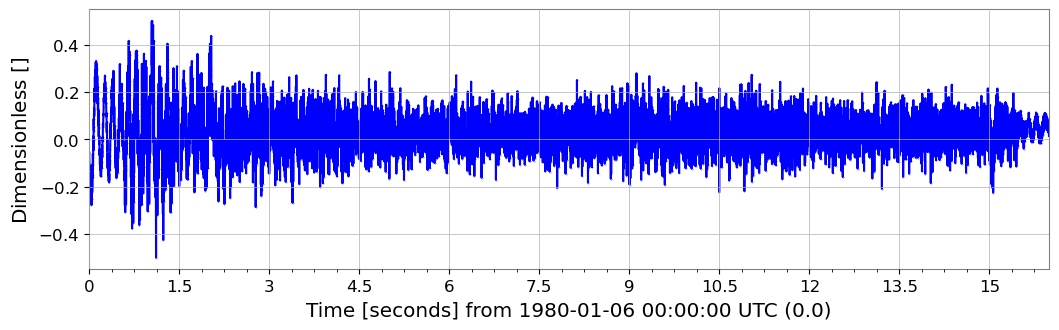

In [110]:
ts_res= TimeSeries(df.iloc[0,0],dt=1.0/500.0)
ts_orig= TimeSeries(df_stand.iloc[0,0],dt=1.0/500.0)
ts_res.plot(color='r', marker='o',markersize=0.2)
ts_orig.plot(color='b', marker='o',markersize=0.2)
plt.show()

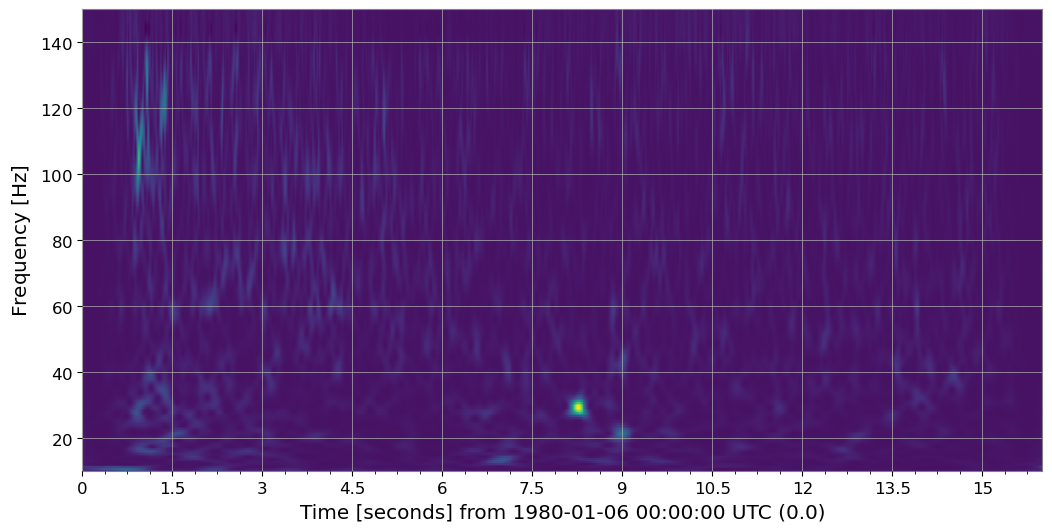

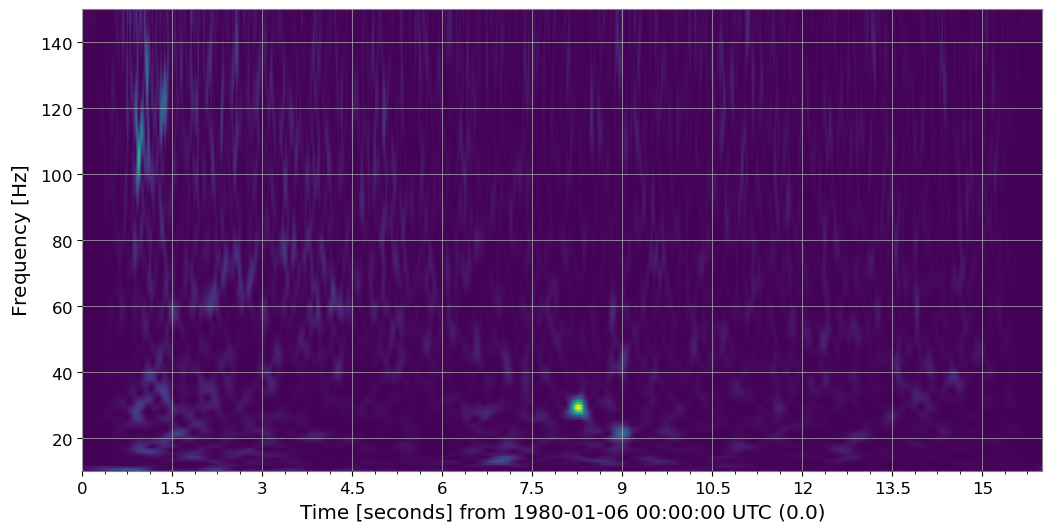

In [51]:
ts_res.q_transform(frange=(10,150)).plot()
ts_orig.q_transform(frange=(10,150)).plot()
plt.show()

## Split Data

In [10]:
#create a df with only aux channels
# df_aux = pd.DataFrame(df_norm[['V1:LSC_MICH_ERR', 'V1:LSC_NE_CORR','V1:LSC_PR_CORR']])
# df_main=pd.DataFrame(df_norm['V1:Hrec_hoft_16384Hz'])
#df_aux = pd.DataFrame(df_stand[['V1:LSC_MICH_ERR', 'V1:LSC_NE_CORR','V1:LSC_PR_CORR']])
#df_main=pd.DataFrame(df_stand['V1:Hrec_hoft_16384Hz'])
df_aux_all = pd.DataFrame(df_filtered[['V1:LSC_MICH_ERR', 'V1:LSC_NE_CORR','V1:LSC_PR_CORR']])
df_main_all = pd.DataFrame(df_filtered['V1:Hrec_hoft_16384Hz'])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df_aux_all, df_main_all, test_size=0.1, random_state=42)

#signal_data_train=torch.stack([torch.stack([df['V1:Hrec_hoft_16384Hz'][i]]) for i in range(n_train)])
#aux_data_train=torch.stack([torch.stack([df_aux.loc[i][0],df_aux.loc[i][1],df_aux.loc[i][2],df_aux.loc[i][3],df_aux.loc[i][4]]) for i in range(n_train)])
signal_data_train = torch.stack([torch.stack([y_train['V1:Hrec_hoft_16384Hz'].iloc[i]]) for i in range(y_train.shape[0])])
aux_data_train = torch.stack([torch.stack([X_train.iloc[i][0], X_train.iloc[i][1], X_train.iloc[i][2]]) for i in range(X_train.shape[0])])

train_data=torch.cat([signal_data_train,aux_data_train],dim=1) 
print(signal_data_train.shape)
print(aux_data_train.shape)

# Extract the signal and auxiliary data for testing
signal_data_test = torch.stack([torch.stack([y_test['V1:Hrec_hoft_16384Hz'].iloc[i]]) for i in range(y_test.shape[0])])
aux_data_test = torch.stack([torch.stack([X_test.iloc[i][0], X_test.iloc[i][1], X_test.iloc[i][2]]) for i in range(X_test.shape[0])])

test_data = torch.cat([signal_data_test, aux_data_test], dim=1) 

print(signal_data_test.shape)
print(aux_data_test.shape)

torch.Size([10612, 1, 8000])
torch.Size([10612, 3, 8000])
torch.Size([1180, 1, 8000])
torch.Size([1180, 3, 8000])


In [12]:
batch_size = 10

In [13]:
dataloader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
)

In [14]:
test_dataloader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False,
)

# Model

In [15]:
def init_weights(net, init_type='normal', scaling=0.02):
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv')) != -1:
            torch.nn.init.normal_(m.weight.data, 0.0, scaling)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            torch.nn.init.normal_(m.weight.data, 1.0, scaling)
            torch.nn.init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)  # apply the initialization function 

## Generator

#### If you want to only use the Decoder, just run the next 3 cells and skip directly to the Training part

In [16]:
class Decoder(nn.Module):
    def __init__(self, in_channels, kernel_size=5):
        super(Decoder, self).__init__()

        self.conv1 = nn.Conv1d(in_channels, 64, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.relu1 = nn.LeakyReLU(0.2, inplace=True)

        self.conv2 = nn.Conv1d(64, 128,kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.relu2 = nn.LeakyReLU(0.2, inplace=True)

        self.conv3 = nn.Conv1d(128, 256,kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.relu3 = nn.LeakyReLU(0.2, inplace=True)

        self.conv4 = nn.Conv1d(256, 1, kernel_size=kernel_size, stride=1, padding=kernel_size//2)

    def _forward_features(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.relu3(self.conv3(x))
        x = self.conv4(x)
        return x

    def forward(self, x):
        return self._forward_features(x)

In [17]:
class Decoder_chatgpt(nn.Module):
    def __init__(self, in_channels, kernel_size=5):
        super(Decoder_chatgpt, self).__init__()

        self.conv1 = nn.Conv1d(in_channels, 64, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu1 = nn.LeakyReLU(0.1, inplace=True)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.bn2 = nn.BatchNorm1d(128)
        self.relu2 = nn.LeakyReLU(0.1, inplace=True)

        self.conv3 = nn.Conv1d(128, 256, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.bn3 = nn.BatchNorm1d(256)
        self.relu3 = nn.LeakyReLU(0.1, inplace=True)

        self.conv4 = nn.Conv1d(256, 1, kernel_size=kernel_size, stride=1, padding=kernel_size//2)

    def _forward_features(self, x):
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        x = self.relu3(self.bn3(self.conv3(x)))
        x = self.conv4(x)
        return x

    def forward(self, x):
        return self._forward_features(x)



In [18]:
input_size = 65536*3
hidden_size = batch_size#128
output_size = 65536
num_blocks = 3
generator=Decoder(3).to(device)
generator_chatgpt=Decoder_chatgpt(3).to(device)
init_weights(generator, 'normal', scaling=0.02)
init_weights(generator_chatgpt, 'normal', scaling=0.02)

initialize network with normal
initialize network with normal


### Convolutional UNet

In [33]:
n_data=df.shape[0]
n_train=int(0.9*n_data)
batch_size = 128

signal_data_train=torch.stack([torch.stack([df['V1:Hrec_hoft_16384Hz'][i]]) for i in range(n_train)])
#aux_data_train=torch.stack([torch.stack([df_aux.loc[i][0],df_aux.loc[i][1],df_aux.loc[i][2],df_aux.loc[i][3],df_aux.loc[i][4]]) for i in range(n_train)])

aux_data_train=torch.stack([torch.stack([df_aux.loc[i][0],df_aux.loc[i][1],df_aux.loc[i][2]]) for i in range(n_train)])



train_data=torch.cat([signal_data_train,aux_data_train],dim=1) 
print(signal_data_train.shape)
print(aux_data_train.shape)

signal_data_test=torch.stack([torch.stack([df['V1:Hrec_hoft_16384Hz'][i]]) for i in range(n_train,n_data)])
#aux_data_test=torch.stack([torch.stack([df_aux.loc[i][0],df_aux.loc[i][1],df_aux.loc[i][2],df_aux.loc[i][3],df_aux.loc[i][4]]) for i in range(n_train,n_data)])
aux_data_test=torch.stack([torch.stack([df_aux.loc[i][0],df_aux.loc[i][1],df_aux.loc[i][2]]) for i in range(n_train,n_data)])

test_data=torch.cat([signal_data_test,aux_data_test],dim=1) 
print(signal_data_test.shape)
print(aux_data_test.shape)

torch.Size([2700, 1, 65536])
torch.Size([2700, 3, 65536])
torch.Size([300, 1, 65536])
torch.Size([300, 3, 65536])


In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features, activation=nn.ReLU()):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.Linear(in_features, out_features),
            activation,
            nn.Linear(out_features, in_features)
        )

    def forward(self, x):
        return x + self.block(x)

class ResMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_blocks):
        super(ResMLP, self).__init__()

        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList([
            ResidualBlock(hidden_size, hidden_size) for _ in range(num_blocks)
        ])
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.input_layer(x.view((x.shape[0],-1)))
        for block in self.hidden_layers:
            x = block(x)
        x = self.output_layer(x).unsqueeze(1)
        return x

In [ ]:
input_size = 65536*5
hidden_size = 128
output_size = 65536
num_blocks = 3
generator = ResMLP(input_size, hidden_size, output_size, num_blocks).to(device)

In [13]:
class conbr_block(nn.Module):
    def __init__(self, in_layer, out_layer, kernel_size, stride, dilation):
        super(conbr_block, self).__init__()

        self.conv1 = nn.Conv1d(in_layer, out_layer, kernel_size=kernel_size, stride=stride, dilation = dilation, padding = 3, bias=True)
        self.bn = nn.BatchNorm1d(out_layer)
        self.relu = nn.ReLU()

    def forward(self,x):
        x = self.conv1(x)
        x = self.bn(x)
        out = self.relu(x)

        return out

class se_block(nn.Module):
    def __init__(self,in_layer, out_layer):
        super(se_block, self).__init__()

        self.conv1 = nn.Conv1d(in_layer, out_layer//8, kernel_size=1, padding=0)
        self.conv2 = nn.Conv1d(out_layer//8, in_layer, kernel_size=1, padding=0)
        self.fc = nn.Linear(1,out_layer//8)
        self.fc2 = nn.Linear(out_layer//8,out_layer)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):

        x_se = nn.functional.adaptive_avg_pool1d(x,1)
        x_se = self.conv1(x_se)
        x_se = self.relu(x_se)
        x_se = self.conv2(x_se)
        x_se = self.sigmoid(x_se)

        x_out = torch.add(x, x_se)
        return x_out

class re_block(nn.Module):
    def __init__(self, in_layer, out_layer, kernel_size, dilation):
        super(re_block, self).__init__()

        self.cbr1 = conbr_block(in_layer,out_layer, kernel_size, 1, dilation)
        self.cbr2 = conbr_block(out_layer,out_layer, kernel_size, 1, dilation)
        self.seblock = se_block(out_layer, out_layer)

    def forward(self,x):

        x_re = self.cbr1(x)
        x_re = self.cbr2(x_re)
        x_re = self.seblock(x_re)
        x_out = torch.add(x, x_re)
        return x_out

class UNET_1D(nn.Module):
    def __init__(self ,input_dim,layer_n,kernel_size,depth,out_channels):
        super(UNET_1D, self).__init__()
        self.input_dim = input_dim
        self.layer_n = layer_n
        self.kernel_size = kernel_size
        self.depth = depth

        self.AvgPool1D1 = nn.AvgPool1d(input_dim, stride=5)
        self.AvgPool1D2 = nn.AvgPool1d(input_dim, stride=25)
        self.AvgPool1D3 = nn.AvgPool1d(input_dim, stride=125)

        self.layer1 = self.down_layer(self.input_dim, self.layer_n, self.kernel_size,1, 2)
        self.layer2 = self.down_layer(self.layer_n, int(self.layer_n*2), self.kernel_size,5, 2)
        self.layer3 = self.down_layer(int(self.layer_n*2)+int(self.input_dim), int(self.layer_n*3), self.kernel_size,5, 2)
        self.layer4 = self.down_layer(int(self.layer_n*3)+int(self.input_dim), int(self.layer_n*4), self.kernel_size,5, 2)
        self.layer5 = self.down_layer(int(self.layer_n*4)+int(self.input_dim), int(self.layer_n*5), self.kernel_size,4, 2)

        self.cbr_up1 = conbr_block(int(self.layer_n*7), int(self.layer_n*3), self.kernel_size, 1, 1)
        self.cbr_up2 = conbr_block(int(self.layer_n*5), int(self.layer_n*2), self.kernel_size, 1, 1)
        self.cbr_up3 = conbr_block(int(self.layer_n*3), self.layer_n, self.kernel_size, 1, 1)
        self.upsample = nn.Upsample(scale_factor=5, mode='nearest')
        self.upsample1 = nn.Upsample(scale_factor=5, mode='nearest')

        self.outcov = nn.Conv1d(self.layer_n, out_channels, kernel_size=self.kernel_size, stride=1,padding = 3)


    def down_layer(self, input_layer, out_layer, kernel, stride, depth):
        block = []
        block.append(conbr_block(input_layer, out_layer, kernel, stride, 1))
        for i in range(depth):
            block.append(re_block(out_layer,out_layer,kernel,1))
        return nn.Sequential(*block)

    def forward(self, x):

        pool_x1 = self.AvgPool1D1(x)
        pool_x2 = self.AvgPool1D2(x)
        pool_x3 = self.AvgPool1D3(x)

        #############Encoder#####################

        out_0 = self.layer1(x)
        out_1 = self.layer2(out_0)

        x = torch.cat([out_1,pool_x1],1)
        out_2 = self.layer3(x)

        x = torch.cat([out_2,pool_x2],1)
        x = self.layer4(x)

        #############Decoder####################

        up = self.upsample1(x)
        up = torch.cat([up,out_2],1)
        up = self.cbr_up1(up)

        up = self.upsample(up)
        up = torch.cat([up,out_1],1)
        up = self.cbr_up2(up)

        up = self.upsample(up)
        up = torch.cat([up,out_0],1)
        up = self.cbr_up3(up)

        out = self.outcov(up)

        #out = nn.functional.softmax(out,dim=2)

        return out 

In [95]:
generator =UNET_1D(5,layer_n=32,kernel_size=7,depth=1,out_channels=1).to(device)
init_weights(generator, 'normal', scaling=0.02)
#print(generator)     

initialize network with normal


### Pre training generation

In [ ]:
for batch in(tqdm(test_dataloader)):
    generated=generate_data(generator,batch)
    generated_chatgpt=generate_data(generator_chatgpt,batch)
    break

  0%|          | 0/118 [00:00<?, ?it/s]

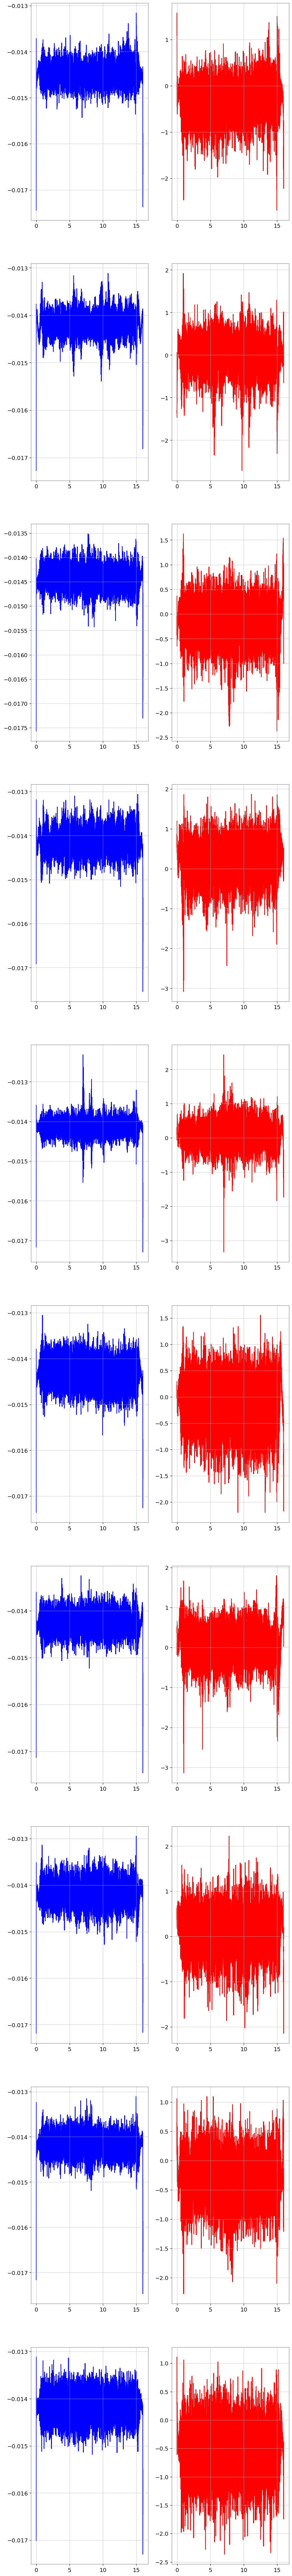

In [ ]:
fig, ax = plt.subplots(nrows=generated.shape[0], ncols=2, figsize=[10, generated.shape[0] * 10])

for i in range(generated.shape[0]):
    generated_signal_ts=TimeSeries(generated[i][0].cpu().numpy())
    generated_signal_ts.dt = 1.0 / 500.0
    
    generated_signal_ts_gpt=TimeSeries(generated_chatgpt[i][0].cpu().numpy())
    generated_signal_ts_gpt.dt = 1.0 / 500.0
    
    
    ax[i,0].plot(generated_signal_ts,color='b',label='Vanilla decoder' )
    ax[i,1].plot(generated_signal_ts_gpt, color='r',label='chat gpt')
    
plt.show()

# Training

In [19]:
# Metric function: IOU

def calculate_iou_2d(generated, target, threshold):
    """
    Calculate Intersection over Union (IoU) in the 2D plane at the specified intensity threshold.

    Parameters:
    - generated: List of time series representing the generated spectrograms
    - target: List of time series representing the target spectrograms
    - threshold: Intensity threshold for determining the binary masks

    Returns:
    - IoU: Intersection over Union
    """
    # Extract spectrogram values from time series
    # print(generated[0][0])
    # print(generated[0][0].shape)
    # print(type(generated[0][0]))
    
    
    spectrograms_gen = [TimeSeries(t[0], dt=1/4096.0).q_transform(frange=(10, 1000)).value for t in generated]
    spectrograms_real = [TimeSeries(t[0], dt=1/4096.0).q_transform(frange=(10, 1000)).value for t in target]

    # Create binary masks based on the intensity threshold
    mask1 = [spectrogram >= threshold for spectrogram in spectrograms_gen]
    mask2 = [spectrogram >= threshold for spectrogram in spectrograms_real]

    # Calculate the intersection and union of the binary masks
    intersection = [np.logical_and(m1, m2) for m1, m2 in zip(mask1, mask2)]
    union = [np.logical_or(m1, m2) for m1, m2 in zip(mask1, mask2)]

    # Calculate Intersection over Union (IoU)
    iou_list = np.array([np.sum(inter) / np.sum(uni) for inter, uni in zip(intersection, union)])

    iou = iou_list.mean()
    return iou


In [20]:
# loss function, learning rate, and optimiser

l2_loss = nn.MSELoss() #this is l2!!!
l1_loss = nn.L1Loss()  #this is L1!!!

lr=0.001

G_optimizer = torch.optim.Adam(generator.parameters(), lr=lr )

In [21]:
#more sophisticated loss function

def log_cosh_loss(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    def _log_cosh(x: torch.Tensor) -> torch.Tensor:
        return x + torch.nn.functional.softplus(-2. * x) - math.log(2.0)
    return torch.mean(_log_cosh(y_pred - y_true))

class LogCoshLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(
        self, y_pred: torch.Tensor, y_true: torch.Tensor
    ) -> torch.Tensor:
        return log_cosh_loss(y_pred, y_true)

# utils function to generate data using the decoder    
def generate_data(generator,batch):
    target = batch[:,0].unsqueeze(1).to(device)
    input = batch[:,1:].to(device)
    #print(input.float())
    with torch.no_grad():
        generated = generator(input.float())
    return generated

In [22]:
def train_decoder(num_epochs,generator,criterion,optimizer,dataloader,val_loader,accuracy,checkpoint_path, save_best=True):
    # num_epochs: (int) number of epochs for training
    # generator: (NN.Module) NN model to train
    # criterion: (torch.optim) optimiser to use in training
    # dataloader: (DataLoader) training data
    # val_loader: (Dataloader) validation data
    # accuracy: (function) metric to measure performance of the model (Note not to be confused with loss)
    # checkpoint_path: (str) full path (including filename in the form filename_{}.pkl so to insert num_epoch) to save checkpoints at
    # save_best: (bool) if you want to save best performing model
    
    
    #uncomment all lines relative to accuracy if you want to measure IOU between generated and real spectrograms.
    #Note that it significantly slows down the whole process
    
    loss_plot =[]
    val_loss_plot =[]
    acc_plot=[]
    val_acc_plot=[]
    best_val_loss=5000000
    for epoch in range(1,num_epochs+1):
        epoch_loss =[]
        epoch_acc=[]
        for i, batch in enumerate(tqdm(dataloader)):
            target = batch[:,0].unsqueeze(1).to(device)
            target=target.float()
            input = batch[:,1:].to(device)
            optimizer.zero_grad()
            generated = generator(input.float())
            loss=criterion(generated,target)
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.detach().cpu().numpy())
            #acc=accuracy(generated.detach().cpu().numpy(),target.detach().cpu().numpy(),20)
            #epoch_acc.append(acc)
        val_loss =[]
        val_acc=[]
        for batch in(tqdm(val_loader)):
            target = batch[:,0].unsqueeze(1).to(device)
            target=target.float()
            input = batch[:,1:].to(device)
            with torch.no_grad():
                generated = generator(input.float())
                loss=criterion(generated,target)
                val_loss.append(loss.detach().cpu().numpy())
                #acc=accuracy(generated.detach().cpu().numpy(),target.detach().cpu().numpy(),20)
                #val_acc.append(acc)
        loss_plot.append(np.mean(epoch_loss))
        val_loss_plot.append(np.mean(val_loss))
        acc_plot.append(np.mean(epoch_acc))
        val_acc_plot.append(np.mean(val_acc))
        #print('epoch: {} loss: {} val loss: {} accuracy: {} val accuracy: {}'.format(epoch,loss_plot[-1],val_loss_plot[-1],acc_plot[-1],val_acc_plot[-1]))
        print('epoch: {} loss: {} val loss: {}'.format(epoch,loss_plot[-1],val_loss_plot[-1]))
        
        # Save checkpoint every 100 epochs
        if epoch % 100 == 0:
            #uncomment the following if you want to save checkpoint every 100 epochs regardless of the performance of the model
            # checkpoint = {
            #     'epoch': epoch,
            #     'model_state_dict': generator.state_dict(),
            #     'optimizer_state_dict': optimizer.state_dict(),
            #     'loss': loss_plot[-1],
            #     'val_loss': val_loss_plot[-1],
            # }
            
            # checkpoint_filename = checkpoint_path.format(epoch)
            # torch.save(checkpoint, checkpoint_filename)
            
            if save_best and val_loss_plot[-1] < best_val_loss: # instead of val_loss and best_val loss we should use accuracy!!!
                #create checkpoint
                checkpoint = {
                'epoch': epoch,
                'model_state_dict': generator.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss_plot[-1],
                'val_loss': val_loss_plot[-1],
                }
                
                #save checkpoint only if it is better than the previous ones
                checkpoint_filename = checkpoint_path.format(epoch)
                torch.save(checkpoint, checkpoint_filename)
                
                #update best model
                best_val_loss = val_loss_plot[-1]
                best_checkpoint_filename = checkpoint_path.format('best')
                torch.save(checkpoint, best_checkpoint_filename)
        
        
    return loss_plot, val_loss_plot,acc_plot, val_acc_plot #,acc_plot, val_acc_plot,

In [ ]:
save_checkpoint='/home/jovyan/checkpoints/all_data/checkpoint_epoch_{}.pth'
n_epochs=1000

In [ ]:
loss_plot, val_loss_plot,acc_plot, val_acc_plot=train_decoder(n_epochs,generator,l1_loss,G_optimizer,dataloader,test_dataloader,calculate_iou_2d,save_chekpoint)

  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 1 loss: 0.09329631924629211 val loss: 0.0914795771241188


/envs/pytorch-intertwin/v0.0.0/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/envs/pytorch-intertwin/v0.0.0/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 2 loss: 0.09128794819116592 val loss: 0.09077975898981094


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 3 loss: 0.09066180884838104 val loss: 0.09105995297431946


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 4 loss: 0.09047675132751465 val loss: 0.09020712226629257


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 5 loss: 0.09028260409832001 val loss: 0.0900815948843956


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 6 loss: 0.09020425379276276 val loss: 0.08982514590024948


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 7 loss: 0.09012264758348465 val loss: 0.09001275897026062


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 8 loss: 0.09006021916866302 val loss: 0.08987968415021896


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 9 loss: 0.0900750607252121 val loss: 0.08990463614463806


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 10 loss: 0.09001908451318741 val loss: 0.08961181342601776


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 11 loss: 0.08997677266597748 val loss: 0.08960435539484024


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 12 loss: 0.08994980901479721 val loss: 0.09021581709384918


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 13 loss: 0.08994225412607193 val loss: 0.08968858420848846


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 14 loss: 0.08987852185964584 val loss: 0.08974982798099518


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 15 loss: 0.0899219661951065 val loss: 0.0894763246178627


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 16 loss: 0.08989688009023666 val loss: 0.08949597924947739


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 17 loss: 0.08986704051494598 val loss: 0.08962615579366684


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 18 loss: 0.089845672249794 val loss: 0.08947905898094177


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 19 loss: 0.08982589095830917 val loss: 0.08962243795394897


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 20 loss: 0.08986465632915497 val loss: 0.08951513469219208


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 21 loss: 0.08982490003108978 val loss: 0.08982715755701065


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 22 loss: 0.08980312943458557 val loss: 0.08960168063640594


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 23 loss: 0.08980068564414978 val loss: 0.08950107544660568


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 24 loss: 0.08980560302734375 val loss: 0.0895199179649353


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 25 loss: 0.08977916836738586 val loss: 0.0898372083902359


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 26 loss: 0.08980665355920792 val loss: 0.08948034048080444


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 27 loss: 0.08977116644382477 val loss: 0.08998052030801773


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 28 loss: 0.08979552239179611 val loss: 0.08943837881088257


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 29 loss: 0.08975003659725189 val loss: 0.0894472524523735


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 30 loss: 0.08972804248332977 val loss: 0.08950389921665192


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 31 loss: 0.08978082984685898 val loss: 0.08950283378362656


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 32 loss: 0.08974593132734299 val loss: 0.08969531953334808


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 33 loss: 0.08977347612380981 val loss: 0.0898280218243599


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 34 loss: 0.08972859382629395 val loss: 0.08951698243618011


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 35 loss: 0.089744433760643 val loss: 0.08962037414312363


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 36 loss: 0.0897480845451355 val loss: 0.08958867192268372


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 37 loss: 0.08972568809986115 val loss: 0.08951669931411743


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 38 loss: 0.08971276879310608 val loss: 0.08934221416711807


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 39 loss: 0.08975522965192795 val loss: 0.0899793952703476


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 40 loss: 0.08973373472690582 val loss: 0.08945252746343613


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 41 loss: 0.08970363438129425 val loss: 0.08944927901029587


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 42 loss: 0.08970389515161514 val loss: 0.0899016261100769


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 43 loss: 0.08972495794296265 val loss: 0.08946368843317032


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 44 loss: 0.08969344943761826 val loss: 0.08941598981618881


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 45 loss: 0.08970379084348679 val loss: 0.08954782783985138


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 46 loss: 0.08969918638467789 val loss: 0.08967406302690506


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 47 loss: 0.08970702439546585 val loss: 0.08942481130361557


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 48 loss: 0.08970201760530472 val loss: 0.08945751190185547


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 49 loss: 0.08967550098896027 val loss: 0.0893518477678299


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 50 loss: 0.08968551456928253 val loss: 0.08969451487064362


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 51 loss: 0.08971583098173141 val loss: 0.0894760712981224


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 52 loss: 0.08967850357294083 val loss: 0.08969701826572418


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 53 loss: 0.08967389166355133 val loss: 0.08957064896821976


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 54 loss: 0.08968579024076462 val loss: 0.08932406455278397


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 55 loss: 0.0896521508693695 val loss: 0.08946841210126877


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 56 loss: 0.08967263996601105 val loss: 0.08946085721254349


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 57 loss: 0.08968967944383621 val loss: 0.08946645259857178


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 58 loss: 0.08967455476522446 val loss: 0.08941751718521118


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 59 loss: 0.08965326100587845 val loss: 0.08959303051233292


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 60 loss: 0.08967941254377365 val loss: 0.0897803008556366


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 61 loss: 0.08965510874986649 val loss: 0.08941527456045151


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 62 loss: 0.08965780586004257 val loss: 0.08941732347011566


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 63 loss: 0.08968090265989304 val loss: 0.08948258310556412


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 64 loss: 0.08966225385665894 val loss: 0.08944942057132721


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 65 loss: 0.0896785631775856 val loss: 0.08951586484909058


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 66 loss: 0.08966576308012009 val loss: 0.08932988345623016


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 67 loss: 0.08965576440095901 val loss: 0.08937741816043854


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 68 loss: 0.0896613597869873 val loss: 0.08940070867538452


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 69 loss: 0.08965039998292923 val loss: 0.08954198658466339


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 70 loss: 0.08965999633073807 val loss: 0.08973997086286545


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 71 loss: 0.089638851583004 val loss: 0.08940479904413223


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 72 loss: 0.08968893438577652 val loss: 0.0894111767411232


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 73 loss: 0.0896812304854393 val loss: 0.08943694829940796


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 74 loss: 0.08964671194553375 val loss: 0.08940786123275757


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 75 loss: 0.08963298797607422 val loss: 0.0893658921122551


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 76 loss: 0.08965276181697845 val loss: 0.0899454802274704


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 77 loss: 0.08964499831199646 val loss: 0.08940241485834122


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 78 loss: 0.0896512046456337 val loss: 0.08943947404623032


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 79 loss: 0.08965985476970673 val loss: 0.08946110308170319


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 80 loss: 0.08961706608533859 val loss: 0.0894106850028038


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 81 loss: 0.08962120115756989 val loss: 0.08942797780036926


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 82 loss: 0.089649997651577 val loss: 0.08942597359418869


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 83 loss: 0.08963258564472198 val loss: 0.08946265280246735


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 84 loss: 0.08965889364480972 val loss: 0.08953040093183517


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 85 loss: 0.08961018174886703 val loss: 0.08937405049800873


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 86 loss: 0.08966166526079178 val loss: 0.08938513696193695


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 87 loss: 0.08963342010974884 val loss: 0.08976524323225021


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 88 loss: 0.0896390900015831 val loss: 0.08927816152572632


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 89 loss: 0.08963501453399658 val loss: 0.08941500633955002


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 90 loss: 0.08961477875709534 val loss: 0.08946196734905243


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 91 loss: 0.08961282670497894 val loss: 0.08934561908245087


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 92 loss: 0.0896371603012085 val loss: 0.08945722877979279


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 93 loss: 0.08963137865066528 val loss: 0.08945770561695099


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 94 loss: 0.08960504829883575 val loss: 0.0898570716381073


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 95 loss: 0.08962687849998474 val loss: 0.08937178552150726


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 96 loss: 0.08963427692651749 val loss: 0.08950776606798172


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 97 loss: 0.08962363749742508 val loss: 0.08933181315660477


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 98 loss: 0.08964940905570984 val loss: 0.08951185643672943


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 99 loss: 0.08964565396308899 val loss: 0.08965422958135605


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 100 loss: 0.08958343416452408 val loss: 0.08960377424955368


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 101 loss: 0.08963429927825928 val loss: 0.0894172415137291


  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

epoch: 102 loss: 0.08961997181177139 val loss: 0.08958616107702255


  0%|          | 0/1062 [00:00<?, ?it/s]

In [37]:
#save model in native PyTorch format (.pth or .pt)
torch.save(generator_chatgpt.state_dict(), 'generator_gpt_weights_100_epochs.pth')
print('Model saved')

Model saved


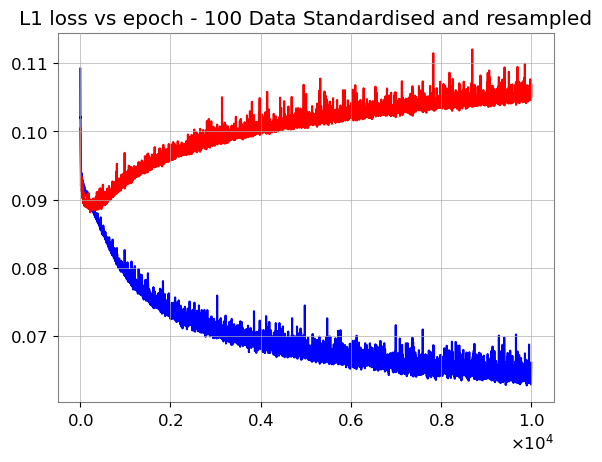

In [27]:
# Plotting the loss
import matplotlib.pyplot as plt
plt.plot(loss_plot,color='b',label='train')
plt.plot(val_loss_plot,color='r',label='validation')
plt.title('L1 loss vs epoch - 100 Data Standardised and resampled')
plt.show()

# Plotting The Syntetic Signals

### Load Checkpoint

In [28]:
# Define the path to your checkpoint file
checkpoint_path = '/home/jovyan/checkpoints/checkpoint_epoch_best.pth'

# Load the checkpoint
checkpoint = torch.load(checkpoint_path)

# Load the model state from the checkpoint
generator.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [12]:
from gwpy.timeseries import TimeSeries
import matplotlib.pyplot as plt

In [ ]:
#Generate data for first batch
for batch in test_dataloader:
    generated=generate_data(generator,batch)
    break

### **Plotting Spectrograms**

In [34]:
# utils function to calculate IOU during inference
def calculate_iou_2d_inference(spec_generated, spec_target, threshold):
    """
    Calculate Intersection over Union (IoU) in the 2D plane at the specified intensity threshold.

    Parameters:
    - generated: List of time series representing the generated spectrograms
    - target: List of time series representing the target spectrograms
    - threshold: Intensity threshold for determining the binary masks

    Returns:
    - IoU: Intersection over Union
    """
    # Extract spectrogram values from time series
    

    # Create binary masks based on the intensity threshold
    mask1 = spec_generated >= threshold 
    mask2 = spec_target >= threshold 

    # Calculate the intersection and union of the binary masks
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2) 

    # Calculate Intersection over Union (IoU)
    iou= np.sum(intersection) / np.sum(union) 

    return iou


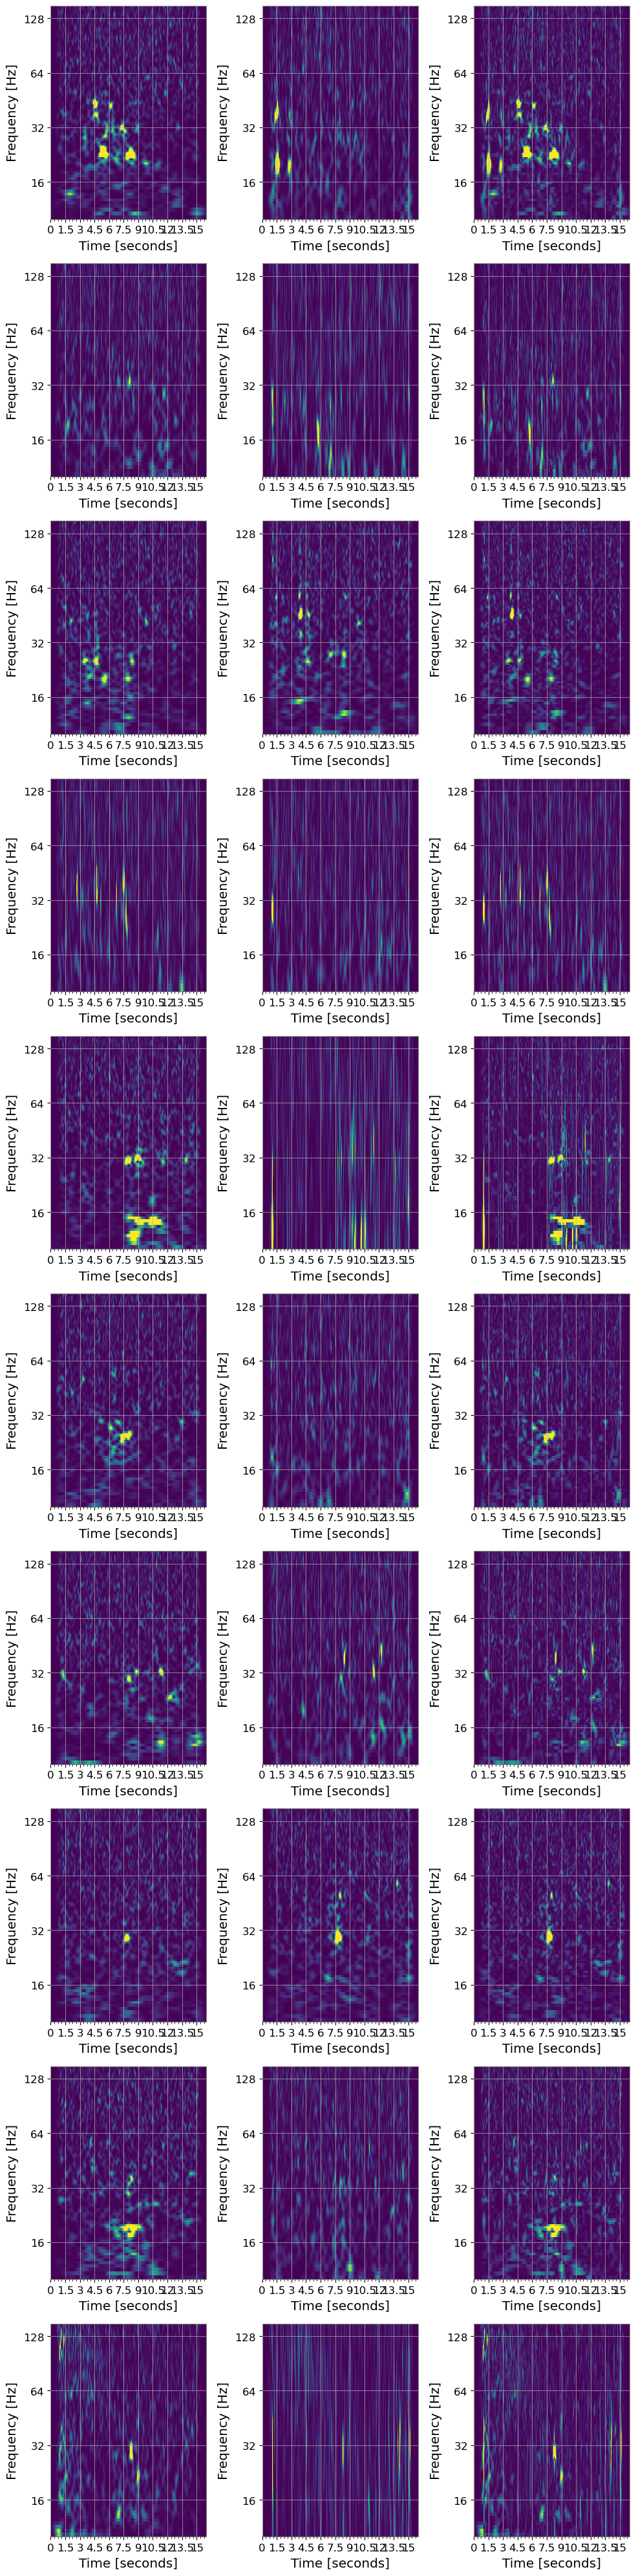

In [37]:
# Create a single figure for all subplots
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=[10, 4 * 10])
iou_list=[]
for i in range(10):
    real_signal_ts = TimeSeries(signal_data_test[i][0].cpu().numpy())
    real_signal_ts.dt = 1.0 / 500.0
    #real_signal_ts.whiten()
    real_qspecgram = real_signal_ts.q_transform(frange=(10, 150))

    
    
    tmsrs = TimeSeries(generated[i][0].cpu().numpy())
    tmsrs.dt = 1.0 / 500.0
    #tmsrs = tmsrs.whiten()
    qspecgram = tmsrs.q_transform(frange=(10, 150))

    #calculate IOU between real and generated spectrograms
    iou=calculate_iou_2d_inference(qspecgram, real_qspecgram, 20)
    iou_list.append(iou)
    
    # Plot on the specified subplot
    axes[i, 0].imshow(real_qspecgram, cmap='viridis', aspect='auto', origin='lower', vmin=0, vmax=25)
    axes[i, 1].imshow(qspecgram, cmap='viridis', aspect='auto', origin='lower', vmin=0, vmax=25)
    axes[i, 2].imshow(abs(real_qspecgram-qspecgram), cmap='viridis', aspect='auto', origin='lower', vmin=0, vmax=25)

    axes[i, 0].set_xscale('seconds')
    axes[i, 0].set_yscale('log', base=2)
    axes[i, 0].set_ylim(10, 150)
    axes[i, 0].set_ylabel('Frequency [Hz]')
    axes[i, 0].set_xlabel('Time [seconds]')

    axes[i, 1].set_xscale('seconds')
    axes[i, 1].set_yscale('log', base=2)
    axes[i, 1].set_ylim(10, 150)
    axes[i, 1].set_ylabel('Frequency [Hz]')
    axes[i, 1].set_xlabel('Time [seconds]')
    
    axes[i, 2].set_xscale('seconds')
    axes[i, 2].set_yscale('log', base=2)
    axes[i, 2].set_ylim(10, 150)
    axes[i, 2].set_ylabel('Frequency [Hz]')
    axes[i, 2].set_xlabel('Time [seconds]')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Save the entire figure as a single PNG file
plt.savefig('fake_v_real_decoder_all.png')
plt.show()


In [43]:
#IOU between real and generated spectrograms
iou_list

[0.0008066467693796886,
 0.004842615012106538,
 0.0008435970980259828,
 0.002080856123662307,
 0.0003683919690550746,
 0.0019672131147540984,
 0.0053275901156200406,
 0.00146163215590743,
 0.00209819555182543,
 0.00227653965971723]

### **Plotting generated signals**

In [ ]:
fig, ax = plt.subplots(nrows=generated.shape[0], ncols=2, figsize=[10, generated.shape[0] * 10])

for i in range(generated.shape[0]):
    generated_signal_ts=TimeSeries(generated[i][0].cpu().numpy())
    generated_signal_ts.dt = 1.0 / 500.0  #Note: if not using resampled (or with different resampling) data you must change 1.0/500.0 by hand
    
    # generated_signal_ts_gpt=TimeSeries(generated_chatgpt[i][0].cpu().numpy())
    # generated_signal_ts_gpt.dt = 1.0 / 4096.0 
    
    
    real_signal_ts=TimeSeries(signal_data_test[i][0].cpu().numpy())
    real_signal_ts.dt = 1.0 / 500.0 #Note: if not using resampled (or with different resampling) data you must change 1.0/500.0 by hand
    
    ax[i,0].plot(real_signal_ts,color='b',label='Real' )
    ax[i,1].plot(generated_signal_ts, color='r',label='Generated')
    
    
plt.show()

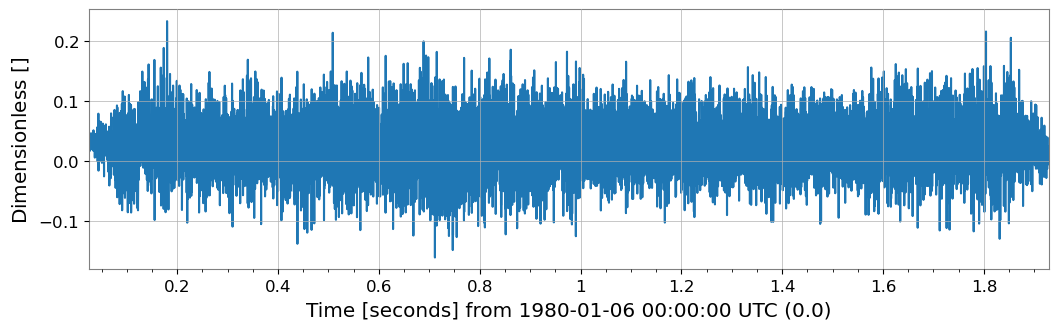

In [30]:
generated_signal_ts=TimeSeries(generated[0][0].cpu().numpy())
generated_signal_ts.dt = 1.0 / 4096.0
generated_signal_ts[100:-100].plot()
plt.show()

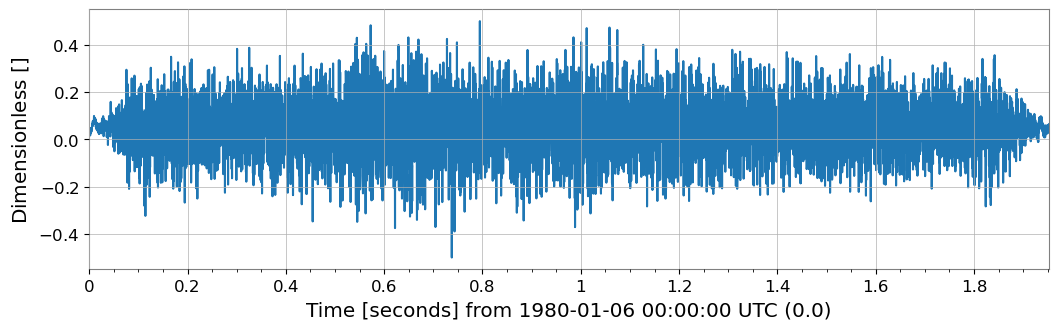

In [31]:
real_signal_ts=TimeSeries(signal_data_test[0][0].cpu().numpy())
real_signal_ts.dt = 1.0 / 4096.0
real_signal_ts.plot()
plt.show()